<a href="https://colab.research.google.com/github/Imranzr/Developing_EEG_Based_Auditory_Brain_Computer_Interface_Using_Deep_Learning_-_Machine_Learning_Model/blob/main/DL_eegnet_deep_Auditory_BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install mne

In [3]:
pip install pyriemann

In [4]:
import os
import argparse
import sys
import mne
import math
import time
import json
import numpy as np
from scipy.signal import butter, filtfilt
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, matthews_corrcoef

start = time.time()


def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True
        elif shell == 'TerminalInteractiveShell':
            return False
        else:
            return False
    except NameError:
        return False
if is_notebook():
    args = argparse.Namespace(s=None, c=None)
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('-s', default=None)
    parser.add_argument('-c', default=None, type=int)
    args = parser.parse_args(args=[])

print(args.s)
print(args.c)

print(__doc__)

subject = 'sub-I'
if args.s is not None:
    subject = args.s
test_class =1
if args.c is not None:
    test_class = args.c

import numpy as np
fnum = np.array([[1,4],
                 [2,5],
                 [3,6]])

trig_id = [2,8,32]
tasks = ['low', 'low', 'mid', 'mid', 'high', 'high']
reject={'eeg':100e-6,'eog':500e-6}

import os
import json
repository_base = os.path.dirname(os.path.dirname(os.path.abspath('/content/drive/MyDrive/dataverse_files/results/sub-I_classification_scores.json')))

base = os.path.join(repository_base, "eeg")
save_base = os.path.join(repository_base, "results")
if not os.path.exists(save_base):
    os.makedirs(save_base)

Fs = 1000
fc = [1, 40]
resample = None
from scipy.signal import butter, filtfilt
def apply_filter(data, b, a):
    r = filtfilt(b=b, a=a, x=data)
    return r
b,a = butter(N = 2, Wn = np.array(fc)/(Fs/2), btype = 'bandpass', output = 'ba')



t_file = []
nt_file = []
target_file = []
non_target_file = []


for i in range(len(fnum.ravel())):
    fname = os.path.join(base, subject, "eeg", "%s_task-%s_run-%d_eeg.vhdr" % (subject, tasks[i], fnum.ravel()[i]))
    print(fname)
    if np.any(fnum[test_class-1] == fnum.ravel()[i]):
        if isinstance(target_file, list):
            target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            target_file = target_file.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            t_file.append(fnum.ravel()[i])
        else:
            tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            tmp = tmp.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            target_file = mne.concatenate_raws([target_file, tmp])
            t_file.append(fnum.ravel()[i])
    else:
        if isinstance(non_target_file, list):
            non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            non_target_file = non_target_file.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            nt_file.append(fnum.ravel()[i])
        else:
            tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            tmp = tmp.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            non_target_file = mne.concatenate_raws([non_target_file, tmp])
            nt_file.append(fnum.ravel()[i])
if resample is not None:
    target_file.resample(resample)
    non_target_file.resample(resample)
if resample != None:
    target_file.resample(resample)
    non_target_file.resample(resample)


event_id={'target_stimulus_id':-100,'non_target_stimulus_id':-500}
target_eve = mne.events_from_annotations(target_file)
target_eve = mne.merge_events(target_eve[0],[trig_id[test_class-1]],event_id['target_stimulus_id'],replace_events=True)
non_target_eve = mne.events_from_annotations(non_target_file)
non_target_eve = mne.merge_events(non_target_eve[0],[trig_id[test_class-1]],event_id['non_target_stimulus_id'],replace_events=True)



tmin,tmax= -0.02, 1.4
baseline=(0.0,0.01)
target_epochs = mne.Epochs(target_file,events=target_eve, event_id=event_id['target_stimulus_id'], tmin=tmin,tmax=tmax, baseline=baseline, reject=reject,preload = True)









import numpy as np
def find_max_peak_window(data, Fs, window_size_ms=600, overlap_size_ms=200, epoch_index=0):
    """
    Function to find the window with the maximum peak value within a specific epoch and return its start and end indices.
    """
    window_size_samples = int(window_size_ms * Fs / 1000)
    overlap_size_samples = int(overlap_size_ms * Fs / 1000)

    epoch_data = data[epoch_index]
    n_channels, n_times = epoch_data.shape
    max_peak_value = -np.inf
    max_peak_start_index = None
    max_peak_end_index = None


    start = 0
    while start + window_size_samples <= n_times:
        window_data = epoch_data[:, start:start + window_size_samples]
        current_peak_value = np.max(window_data)
        if current_peak_value > max_peak_value:
            max_peak_value = current_peak_value
            max_peak_start_index = start
            max_peak_end_index = start + window_size_samples - 1
        start += (window_size_samples - overlap_size_samples)
    print(f"Epoch {epoch_index + 1} - Max Peak Value: {max_peak_value}")
    print(f"Epoch {epoch_index + 1} - Window Start Index: {max_peak_start_index}, End Index: {max_peak_end_index}")
    return max_peak_start_index, max_peak_end_index


def analyze_all_epochs_max_peaks(data, Fs, window_size_ms=600, overlap_size_ms=200):
    """
    Function to find and print the maximum peak values and corresponding window indices across all epochs.
    """
    n_epochs = data.shape[0]
    peak_window_indices = []
    for epoch_index in range(n_epochs):
        print(f"\nAnalyzing Epoch {epoch_index + 1}")
        start_index, end_index = find_max_peak_window(data, Fs, window_size_ms, overlap_size_ms, epoch_index)
        peak_window_indices.append((start_index, end_index))
    return peak_window_indices

def re_epoch_data(data, peak_window_indices):
    """
    Function to re-epoch the data based on the peak window indices.
    """
    re_epoched_data = []
    for epoch_index, (start, end) in enumerate(peak_window_indices):
        re_epoched_epoch_data = data[epoch_index][:, start:end + 1]
        re_epoched_data.append(re_epoched_epoch_data)
    re_epoched_data = np.array(re_epoched_data)
    print("\nRe-epoching complete.")
    print("Re-epoched data shape:", re_epoched_data.shape)
    return re_epoched_data

Fs = 1000
data = target_epochs.get_data()

peak_window_indices = analyze_all_epochs_max_peaks(data, Fs, window_size_ms=600, overlap_size_ms=200)
re_epoched_data = re_epoch_data(data, peak_window_indices)


from mne import EpochsArray
from mne import create_info
n_channels = re_epoched_data.shape[1]
info = create_info(ch_names=[f'chan{i}' for i in range(n_channels)], sfreq=Fs, ch_types='eeg')
re_epoched_epochs = EpochsArray(re_epoched_data, info)

print("Re-epoched data converted to MNE Epochs:", re_epoched_epochs)
from mne import EpochsArray, create_info


n_channels = re_epoched_data.shape[1]
info = create_info(ch_names=[f'chan{i}' for i in range(n_channels)], sfreq=Fs, ch_types='eeg')
re_epoched_epochs = EpochsArray(re_epoched_data, info)
baseline=(0.0,0.01)
re_epoched_epochs.apply_baseline(baseline)


re_epoched_epochs.filter(l_freq=0.50, h_freq=100.00)
print("Re-epoched data converted to MNE Epochs and processed with baseline correction and filtering.")




tmin,tmax= -0.0, 0.599
baseline=(0.0,0.01)
non_target_epochs = mne.Epochs(non_target_file, events=non_target_eve, event_id=event_id['non_target_stimulus_id'], tmin=tmin,tmax=tmax, baseline=baseline, reject=reject,preload = True)


import mne
tmin, tmax = -0.0, 0.599
baseline=(0.0,0.01)

non_target_epochs = mne.Epochs(
    non_target_file,
    events=non_target_eve,
    event_id=event_id['non_target_stimulus_id'],
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    reject=reject,
    preload=True
)

new_channel_names = [f'chan{i}' for i in range(len(non_target_epochs.ch_names))]
rename_dict = dict(zip(non_target_epochs.ch_names, new_channel_names))
non_target_epochs.rename_channels(rename_dict)
print("Updated channel names:", non_target_epochs.ch_names)

epochs = mne.concatenate_epochs([re_epoched_epochs, non_target_epochs])
epochs = epochs.copy().pick_types(eeg=True, eog=False)

epochs_data = epochs.get_data()
labels = epochs.events[:, -1]
preds = np.zeros(len(labels))

None
None
Automatically created module for IPython interactive environment
/content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-low_run-1_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-low_run-1_eeg.vhdr...
Setting channel info structure...


<ipython-input-4-688ac7c057cd>:91: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-688ac7c057cd>:91: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


Reading 0 ... 320039  =      0.000 ...   320.039 secs...
/content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-low_run-4_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-low_run-4_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 309439  =      0.000 ...   309.439 secs...


<ipython-input-4-688ac7c057cd>:95: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-688ac7c057cd>:95: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-mid_run-2_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-mid_run-2_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 313639  =      0.000 ...   313.639 secs...


<ipython-input-4-688ac7c057cd>:101: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-688ac7c057cd>:101: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-mid_run-5_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-mid_run-5_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 311839  =      0.000 ...   311.839 secs...


<ipython-input-4-688ac7c057cd>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-688ac7c057cd>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-high_run-3_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-high_run-3_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 311919  =      0.000 ...   311.919 secs...


<ipython-input-4-688ac7c057cd>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-688ac7c057cd>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-high_run-6_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-I/eeg/sub-I_task-high_run-6_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 315159  =      0.000 ...   315.159 secs...


<ipython-input-4-688ac7c057cd>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-688ac7c057cd>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8', 'Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S144']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8', 'Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S144']
Not setting metadata
111 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 111 events and 1421 original time points ...
    Rejecting  epoch based on EOG : ['vEOG']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AFz', 'AF4', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EOG : ['vEOG']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EOG : ['vEOG']
    Rejecting  epoch based on EEG

<ipython-input-4-688ac7c057cd>:215: RuntimeWarning: filter_length (6601) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  re_epoched_epochs.filter(l_freq=0.50, h_freq=100.00)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 3041 

Re-epoched data converted to MNE Epochs and processed with baseline correction and filtering.
Not setting metadata
232 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 232 events and 600 original time points ...
    Rejecting  epoch based on EOG : ['vEOG']
    Rejecting  epoch based on EEG : ['Fp2']
2 bad epochs dropped
Not setting metadata
232 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 232 events and 600 original time points ...
    Rejecting  epoch based on EOG : ['vEOG']
    Rejecting  epoch based on EEG : ['Fp2']
2 bad epochs dropped
Updated channel names: ['chan0', 'chan1', 'chan2', 'chan3', 'chan4', 'chan5', 'chan6', 'chan7', 'chan8', 'chan9', 'chan10', 'chan11', 'chan12', 'chan13', 'chan14', 'chan15', 'chan16', 'chan17', 'chan18', 'chan19', 'chan20', 'chan21', 'chan22', 'chan23', 'chan24', 'chan25', 'chan26', 'chan27', 

<ipython-input-4-688ac7c057cd>:246: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([re_epoched_epochs, non_target_epochs])


Applying baseline correction (mode: mean)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [5]:
re_epoched_epochs

<EpochsArray | 100 events (all good), 0 – 0.599 s (baseline 0 – 0.01 s), ~30.3 MB, data loaded,
 '1': 100>

In [6]:
non_target_epochs

<Epochs | 230 events (all good), 0 – 0.599 s (baseline 0 – 0.01 s), ~69.6 MB, data loaded,
 '-500': 230>

In [7]:
labels

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1, -500, -500, -500, -500, -500, -500, -500, -500, -500, -500,
       -500, -500, -500, -500, -500, -500, -500, -500, -500, -500, -500,
       -500, -500, -500, -500, -500, -500, -500, -500, -500, -500, -500,
       -500, -500, -500, -500, -500, -500, -500, -500, -500, -500, -500,
       -500, -500, -500, -500, -500, -500, -500, -5

In [8]:
import scipy.io as sio
target_data = re_epoched_epochs.get_data()
target_info = {
    'data': target_data,
    'times': target_epochs.times,
    'events': target_epochs.events,
    'event_id': target_epochs.event_id
}
sio.savemat('re_epoched_epochs.mat', target_info)


non_target_data = non_target_epochs.get_data()
non_target_info = {
    'data': non_target_data,
    'times': non_target_epochs.times,
    'events': non_target_epochs.events,
    'event_id': non_target_epochs.event_id
}
sio.savemat('non_target_epochs.mat', non_target_info)

print("MAT files have been successfully saved.")


MAT files have been successfully saved.


In [9]:
non_target_data

array([[[ 3.86138195e-10,  2.68614242e-07,  4.64585459e-07, ...,
          4.50300840e-06,  3.80228397e-06,  3.11647335e-06],
        [ 5.68404398e-07,  6.02140079e-07,  5.83217467e-07, ...,
          2.71352334e-06,  2.41850751e-06,  2.15767106e-06],
        [-4.02709215e-07, -2.46409126e-08,  2.82065306e-07, ...,
          5.32117130e-06,  4.35680807e-06,  3.43392922e-06],
        ...,
        [ 7.39475046e-07,  8.73087256e-07,  9.16355099e-07, ...,
          8.76580464e-06,  8.30346373e-06,  7.83795069e-06],
        [-2.63636364e-07, -2.63636364e-07, -1.63636364e-07, ...,
          4.39363636e-05,  4.39363636e-05,  4.40363636e-05],
        [-1.80000000e-06, -1.00000000e-06, -5.00000000e-07, ...,
         -1.64000000e-05, -1.65000000e-05, -1.63000000e-05]],

       [[ 2.62227660e-06,  2.01844005e-06,  1.37867576e-06, ...,
          5.18736730e-06,  5.26327785e-06,  5.37671685e-06],
        [ 2.91179758e-06,  2.37208863e-06,  1.76771205e-06, ...,
         -3.44766962e-06, -3.36256915e

In [10]:
import torch
from torch import nn

In [11]:
import os
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np

In [13]:
x = sio.loadmat("/content/non_target_epochs.mat")

In [14]:
y = sio.loadmat("/content/re_epoched_epochs.mat")

In [15]:
y

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Dec 17 11:34:09 2024',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[[ 2.57425488e-06,  2.62294444e-06,  2.62855119e-06, ...,
          -7.64774286e-07, -1.31916085e-06, -1.75608243e-06],
         [ 2.16953473e-06,  2.14804786e-06,  2.06182655e-06, ...,
          -2.58277230e-07, -9.29505981e-07, -1.45467749e-06],
         [ 3.48070292e-06,  3.56401789e-06,  3.57924315e-06, ...,
          -4.11479460e-07, -1.03902537e-06, -1.53523896e-06],
         ...,
         [-5.93370392e-07, -7.19614289e-07, -8.57011222e-07, ...,
          -2.08939615e-06, -2.09623859e-06, -2.10268813e-06],
         [-3.30003695e-06, -3.29657040e-06, -3.30096886e-06, ...,
           3.65534163e-06,  3.44469881e-06,  3.26370043e-06],
         [-1.10031889e-05, -1.19015372e-05, -1.28785126e-05, ...,
           3.19657948e-06,  2.87285724e-06,  2.54426429e-06]],
 
        [[ 1.50248571e-07,  5.60329272e-08, -3.27707624e-08, ...,
     

In [16]:
import scipy.io as sio

x = sio.loadmat("/content/non_target_epochs.mat")
y = sio.loadmat("/content/re_epoched_epochs.mat")

print("Keys in non_target_epochs.mat:", x.keys())
print("Keys in target_epochs.mat:", y.keys())


Keys in non_target_epochs.mat: dict_keys(['__header__', '__version__', '__globals__', 'data', 'times', 'events', 'event_id'])
Keys in target_epochs.mat: dict_keys(['__header__', '__version__', '__globals__', 'data', 'times', 'events', 'event_id'])


In [17]:
print("non_target_epochs.mat 'data' shape:", x['data'].shape)
print("/content/re_epoched_epochs.mat 'data' shape:", y['data'].shape)


non_target_epochs.mat 'data' shape: (230, 66, 600)
/content/re_epoched_epochs.mat 'data' shape: (100, 66, 600)


In [18]:
class1 = x['data']
class2 = y['data']

In [19]:
#x = sio.loadmat("/content/non_target_epochs.mat")
#y = sio.loadmat("/content/target_epochs.mat")

#class1=x['Class1_filt']
#class2=y['Class2_filt']

print(class1, class2)
result_combined = np.vstack((class1,class2))

print(result_combined.shape)


a = class1.shape[0]
b = class2.shape[0]

values = [0] * a + [1] * b
labels = np.array(values)
print(labels.shape)

[[[ 3.86138195e-10  2.68614242e-07  4.64585459e-07 ...  4.50300840e-06
    3.80228397e-06  3.11647335e-06]
  [ 5.68404398e-07  6.02140079e-07  5.83217467e-07 ...  2.71352334e-06
    2.41850751e-06  2.15767106e-06]
  [-4.02709215e-07 -2.46409126e-08  2.82065306e-07 ...  5.32117130e-06
    4.35680807e-06  3.43392922e-06]
  ...
  [ 7.39475046e-07  8.73087256e-07  9.16355099e-07 ...  8.76580464e-06
    8.30346373e-06  7.83795069e-06]
  [-2.63636364e-07 -2.63636364e-07 -1.63636364e-07 ...  4.39363636e-05
    4.39363636e-05  4.40363636e-05]
  [-1.80000000e-06 -1.00000000e-06 -5.00000000e-07 ... -1.64000000e-05
   -1.65000000e-05 -1.63000000e-05]]

 [[ 2.62227660e-06  2.01844005e-06  1.37867576e-06 ...  5.18736730e-06
    5.26327785e-06  5.37671685e-06]
  [ 2.91179758e-06  2.37208863e-06  1.76771205e-06 ... -3.44766962e-06
   -3.36256915e-06 -3.21761136e-06]
  [ 1.90930893e-06  1.39249117e-06  8.68547155e-07 ...  7.49515504e-06
    7.42774092e-06  7.40018480e-06]
  ...
  [ 1.58698379e-06  1.2

In [20]:
 X_train, X_test, y_train, y_test = train_test_split(result_combined, labels, test_size=0.2, random_state=42)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, nb_classes=2, kernel_size=60, number_channel=66, signal_length=600,
                 dropoutRate=0.02, pooling_size1=4, pooling_size2=4, f1=8, D=2, f2=16,
                 norm_rate=0.25):
        super(EEGNet, self).__init__()

        # First convolution layer
        self.conv1 = nn.Conv2d(1, f1, (1, kernel_size), padding=(0, kernel_size // 2), bias=False)
        self.batch_norm1 = nn.BatchNorm2d(f1)

        # Depthwise convolution
        self.depthwise_conv = nn.Conv2d(f1, f1 * D, (number_channel, 1), groups=f1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(f1 * D)
        self.elu = nn.ELU()

        # Pooling layer
        self.avg_pool1 = nn.AvgPool2d((1, pooling_size1))
        self.dropout1 = nn.Dropout(dropoutRate)

        # Separable convolution
        self.separable_conv = nn.Conv2d(f1 * D, f2, (1, 16), padding='same', groups=f1 * D, bias=False)
        self.separable_conv_1x1 = nn.Conv2d(f2, f2, (1, 1), padding='same', bias=False)
        self.batch_norm3 = nn.BatchNorm2d(f2)

        # Second pooling layer
        self.avg_pool2 = nn.AvgPool2d((1, pooling_size2))
        self.dropout2 = nn.Dropout(dropoutRate)

        # Calculate the final flattened size after convolutions and pooling
        final_feature_size = 592  # This is the correct flattened size after all layers

        # Correct the input size of the classifier to match final_feature_size
        self.classifier = nn.Linear(final_feature_size, nb_classes)
        self.norm_rate = norm_rate

        # Hooks to apply max norm constraints
        self.depthwise_conv.register_forward_pre_hook(self.apply_max_norm_depthwise)
        self.classifier.register_forward_pre_hook(self.apply_max_norm_classifier)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.depthwise_conv(x)
        x = self.batch_norm2(x)
        x = self.elu(x)
        x = self.avg_pool1(x)
        x = self.dropout1(x)

        x = self.separable_conv(x)
        x = self.separable_conv_1x1(x)
        x = self.batch_norm3(x)
        x = self.elu(x)
        x = self.avg_pool2(x)
        x = self.dropout2(x)

        # Flatten the tensor before passing to the classifier
        x = x.view(x.size(0), -1)  # Flatten the feature maps into a single vector

        x = self.classifier(x)  # Now the input size to classifier is correct
        return x

    def apply_max_norm_depthwise(self, module, input):
        with torch.no_grad():
            norm = self.depthwise_conv.weight.data.norm(2, dim=1, keepdim=True)
            desired = torch.clamp(norm, max=1.0)
            scale = desired / (norm + 1e-8)
            self.depthwise_conv.weight.data *= scale

    def apply_max_norm_classifier(self, module, input):
        with torch.no_grad():
            norm = self.classifier.weight.data.norm(2, dim=0, keepdim=True)
            desired = torch.clamp(norm, max=self.norm_rate)
            scale = desired / (norm + 1e-8)
            self.classifier.weight.data *= scale

# Instantiate the model
model = EEGNet(nb_classes=2, signal_length=600, number_channel=66)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)




# Set loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.AdamW(model.parameters(), lr=0.00059)
#
optimizer = optim.Adam(model.parameters(), lr=0.000012)



Epoch 1/800, Train Loss: 0.5157, Test Loss: 0.6479, Train Accuracy: 0.7689, Test Accuracy: 0.6212
Epoch 2/800, Train Loss: 0.5244, Test Loss: 0.6476, Train Accuracy: 0.7652, Test Accuracy: 0.6364
Epoch 3/800, Train Loss: 0.5153, Test Loss: 0.6444, Train Accuracy: 0.7538, Test Accuracy: 0.6061
Epoch 4/800, Train Loss: 0.5141, Test Loss: 0.6459, Train Accuracy: 0.7652, Test Accuracy: 0.6212
Epoch 5/800, Train Loss: 0.5128, Test Loss: 0.6440, Train Accuracy: 0.7727, Test Accuracy: 0.6212
Epoch 6/800, Train Loss: 0.4962, Test Loss: 0.6454, Train Accuracy: 0.7765, Test Accuracy: 0.6364
Epoch 7/800, Train Loss: 0.5092, Test Loss: 0.6467, Train Accuracy: 0.7576, Test Accuracy: 0.6364
Epoch 8/800, Train Loss: 0.5017, Test Loss: 0.6432, Train Accuracy: 0.7803, Test Accuracy: 0.6515
Epoch 9/800, Train Loss: 0.5127, Test Loss: 0.6445, Train Accuracy: 0.7689, Test Accuracy: 0.6364
Epoch 10/800, Train Loss: 0.5015, Test Loss: 0.6415, Train Accuracy: 0.7879, Test Accuracy: 0.6515
Epoch 11/800, Train

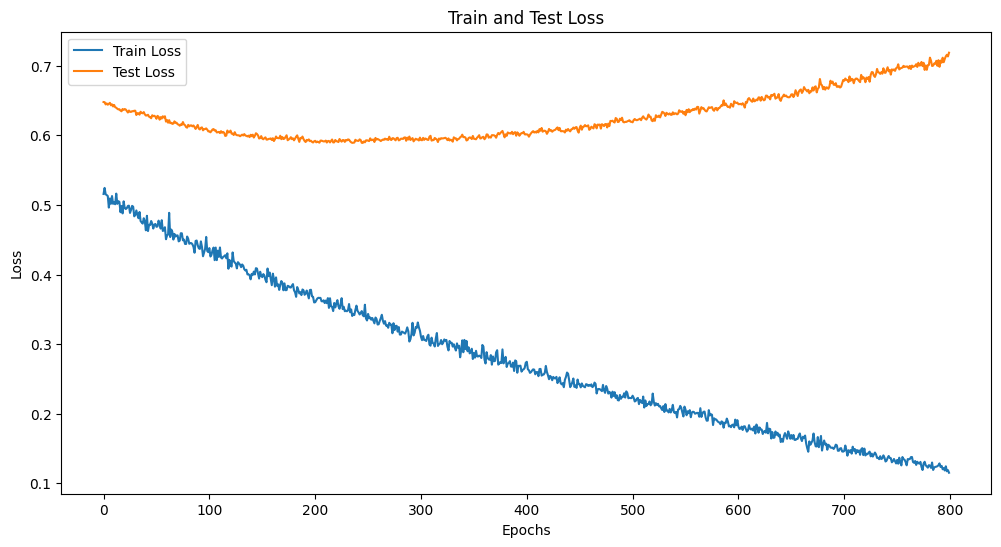

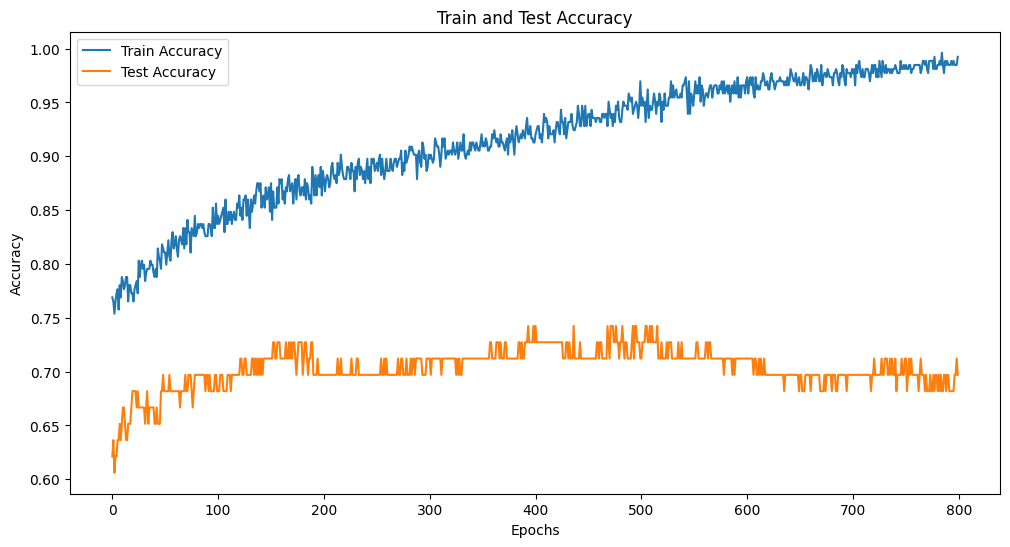

In [35]:
# Initialize lists for accuracy and loss
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Training loop
epochs = 800
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate train accuracy
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Testing loop
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            # Calculate test accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_test += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print stats for the current epoch
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot Training and Test Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

# Plot Training and Test Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()
plt.show()


In [36]:
print(model)

EEGNet(
  (conv1): Conv2d(1, 8, kernel_size=(1, 60), stride=(1, 1), padding=(0, 30), bias=False)
  (batch_norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): Conv2d(8, 16, kernel_size=(66, 1), stride=(1, 1), groups=8, bias=False)
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (avg_pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.02, inplace=False)
  (separable_conv): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=16, bias=False)
  (separable_conv_1x1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
  (batch_norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool2): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout2): Dropout(p=0.02, inplace=False)
  (classifier): Linear(in_features=592, out_features=2, b